### Hyde

### Import Libraries

In [1]:
import os
import dotenv
import pdfplumber
from chromadb import PersistentClient
from chromadb.config import Settings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
from langchain.text_splitter import RecursiveCharacterTextSplitter
import matplotlib.pyplot as plt
import numpy as np
import umap
from tqdm import tqdm
from groq import Groq
import warnings
warnings.simplefilter("ignore")

C:\Users\Susma\Documents\Project\Hyde\hyde\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Environment Variables

In [2]:
dotenv.load_dotenv(dotenv.find_dotenv())
groq_api_key = os.environ["GROQ_API_KEY"]

In [3]:
# Initialize Groq client
client = Groq(api_key=groq_api_key)

### PDF Text Extraction Functions

In [4]:
def extract_two_column_text(pdf_path, page_number):
    with pdfplumber.open(pdf_path) as pdf:
        page = pdf.pages[page_number]
        words = page.extract_words()
        mid_x = (page.bbox[2] - page.bbox[0]) / 2
        
        # Separate words into left and right columns based on mid_x
        left_column = [word['text'] for word in words if word['x0'] < mid_x]
        right_column = [word['text'] for word in words if word['x0'] >= mid_x]
        
        # Combine the two columns
        combined_text = " ".join(left_column + right_column)
        return combined_text

In [5]:
def extract_all_pages_two_column_text(pdf_path):
    extracted_texts = []
    with pdfplumber.open(pdf_path) as pdf:
        for page_number in range(len(pdf.pages)):
            combined_text = extract_two_column_text(pdf_path, page_number)
            extracted_texts.append(combined_text)
    return extracted_texts

### Text Chunking

In [6]:
def split_text_into_chunks(text_list, chunk_size=1000, chunk_overlap=25):
    text_splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n", ". ", " ", ""],
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    all_chunks = []
    for text in text_list:
        all_chunks.extend(text_splitter.split_text(text))
    return all_chunks

### Extract and Process PDF Text

In [7]:
pdf_path = "MCA AR 2023-24 English Final.pdf"

In [8]:
# Extract text from all pages
all_combined_text = extract_all_pages_two_column_text(pdf_path)

# Split the extracted text into chunks
text_chunks = split_text_into_chunks(all_combined_text)

print(f"Total chunks: {len(text_chunks)}")
print(f"Sample chunk: {text_chunks[5]}")

Total chunks: 257
Sample chunk: 29 FOIR Forum of Indian Regulators 30 FRQR Financial Reporting Quality 31 FSDC Financial Stability and Development 32 IAIR International Association 33 IAPs Investor Awareness Programme 34 IBBI Insolvency and Bankruptcy 35 IBC Insolvency and Bankruptcy 36 ICAI Institute of Chartered Accountants 37 ICoAI Institute of Cost Accountants 38 ICLS Indian Corporate Law Service 39 ICLSA Indian Corporate Law Service 40 ICSI Institute of Company Secretaries Machine Learning Committee Act Rules/Regulations Committee of India Bureau Process Corporate Exit Redress and Monitoring System Ofcer Affairs Governance of Commerce and Industry Limited Liability Partnership Review Council of Insolvency Regulators Board of India Code, 2016 of India of India Academy of India


### Initialize ChromaDB

In [9]:
chroma_client = PersistentClient(path="./mca_2023_24")
distilroberta = SentenceTransformerEmbeddingFunction(model_name="all-distilroberta-v1")

In [10]:
# Create or retrieve the collection
collection = chroma_client.get_or_create_collection(
    name="mca_annual_report_2023_24",
    metadata={"title": "MCA Annual Report 2023-24", "description": "Embeddings of MCA Annual Report 2023-24"},
    embedding_function=distilroberta
)

In [33]:
# Add data to the collection
collection.add(
    documents=text_chunks,  
    ids=[f"Split-{idx}" for idx in range(len(text_chunks))]
)

Add of existing embedding ID: Split-0
Add of existing embedding ID: Split-1
Add of existing embedding ID: Split-2
Add of existing embedding ID: Split-3
Add of existing embedding ID: Split-4
Add of existing embedding ID: Split-5
Add of existing embedding ID: Split-6
Add of existing embedding ID: Split-7
Add of existing embedding ID: Split-8
Add of existing embedding ID: Split-9
Add of existing embedding ID: Split-10
Add of existing embedding ID: Split-11
Add of existing embedding ID: Split-12
Add of existing embedding ID: Split-13
Add of existing embedding ID: Split-14
Add of existing embedding ID: Split-15
Add of existing embedding ID: Split-16
Add of existing embedding ID: Split-17
Add of existing embedding ID: Split-18
Add of existing embedding ID: Split-19
Add of existing embedding ID: Split-20
Add of existing embedding ID: Split-21
Add of existing embedding ID: Split-22
Add of existing embedding ID: Split-23
Add of existing embedding ID: Split-24
Add of existing embedding ID: Split

Add of existing embedding ID: Split-208
Add of existing embedding ID: Split-209
Add of existing embedding ID: Split-210
Add of existing embedding ID: Split-211
Add of existing embedding ID: Split-212
Add of existing embedding ID: Split-213
Add of existing embedding ID: Split-214
Add of existing embedding ID: Split-215
Add of existing embedding ID: Split-216
Add of existing embedding ID: Split-217
Add of existing embedding ID: Split-218
Add of existing embedding ID: Split-219
Add of existing embedding ID: Split-220
Add of existing embedding ID: Split-221
Add of existing embedding ID: Split-222
Add of existing embedding ID: Split-223
Add of existing embedding ID: Split-224
Add of existing embedding ID: Split-225
Add of existing embedding ID: Split-226
Add of existing embedding ID: Split-227
Add of existing embedding ID: Split-228
Add of existing embedding ID: Split-229
Add of existing embedding ID: Split-230
Add of existing embedding ID: Split-231
Add of existing embedding ID: Split-232


Insert of existing embedding ID: Split-148
Insert of existing embedding ID: Split-149
Insert of existing embedding ID: Split-150
Insert of existing embedding ID: Split-151
Insert of existing embedding ID: Split-152
Insert of existing embedding ID: Split-153
Insert of existing embedding ID: Split-154
Insert of existing embedding ID: Split-155
Insert of existing embedding ID: Split-156
Insert of existing embedding ID: Split-157
Insert of existing embedding ID: Split-158
Insert of existing embedding ID: Split-159
Insert of existing embedding ID: Split-160
Insert of existing embedding ID: Split-161
Insert of existing embedding ID: Split-162
Insert of existing embedding ID: Split-163
Insert of existing embedding ID: Split-164
Insert of existing embedding ID: Split-165
Insert of existing embedding ID: Split-166
Insert of existing embedding ID: Split-167
Insert of existing embedding ID: Split-168
Insert of existing embedding ID: Split-169
Insert of existing embedding ID: Split-170
Insert of e

### Dimensionality Reduction with UMAP

In [12]:
embeddings = collection.get(include=['embeddings'])['embeddings']
umap_projector = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

def project_embeddings(embeddings, umap_projector):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_projector.transform([embedding])
    return umap_embeddings   

projected_dataset_embeddings = project_embeddings(embeddings, umap_projector)

100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [00:09<00:00, 26.63it/s]


### Visualize Dataset Embeddings

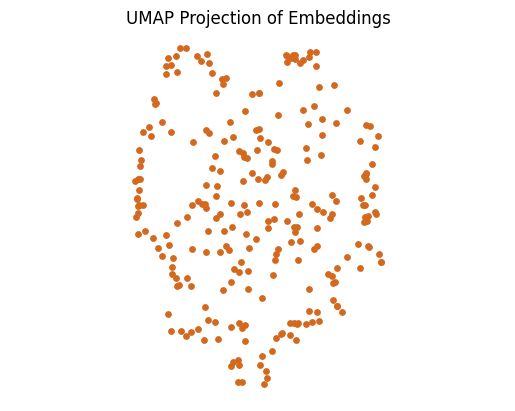

In [13]:
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=15, c="chocolate")
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP Projection of Embeddings')
plt.axis('off');

### Query the Collection

In [14]:
query = "What were the key changes made to the Companies Act in the last fiscal year?"

results = collection.query(query_texts=[query], n_results=10, include=['documents', 'embeddings'])

results.keys()

dict_keys(['ids', 'embeddings', 'documents', 'uris', 'data', 'metadatas', 'distances', 'included'])

In [15]:
retrieved_documents1 = results['documents'][0]

for document in retrieved_documents1:
    print(document)
    print('==========================================')

(iii) The Companies (Miscellaneous) 
Rules, 2014
(iv) The Companies (Accounts) Rules, 
2014
1.1.1 The mandate of the Ministry of 
Corporate Affairs (MCA), inter alia, includes 
the administration of a wide range of statutes 
for the regulation of the corporate sector, as 
given below: 
(i) The Companies Act, 2013/The 
Companies Act, 1956.
(ii) The Limited Liability Partnership Act, 
2008.
(iii) The Competition Act, 2002.
(iv) The Insolvency and Bankruptcy Code, 
2016.
(v) The Chartered Accountants Act, 1949.
(vi) The Cost Accountants Act, 1959.
(vii) The Company Secretaries Act, 1980.
(viii) The Societies Registration Act, 1860 
and Indian Partnership Act, 1932 (in 
centrally administered areas). 
(ix) The Companies (Donations to National 
Funds) Act, 1951.
Functions
1.1.2 The main responsibilities of the 
Ministry are as follows: 
(  ) Administration of the provisions of 
the Companies Act, 2013, and also 
pending/ ongoing works as regards 
the Companies Act, 1956.
CHAPTER-I OVERVIEW 

### Project and Visualize Query Results

In [16]:
retrieved_docs_embeddings = results['embeddings'][0]
original_query_embeddings = distilroberta([query])

projected_original_query_embedding = project_embeddings(original_query_embeddings, umap_projector)
projected_retrieved_embeddings = project_embeddings(retrieved_docs_embeddings, umap_projector)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 133.25it/s]


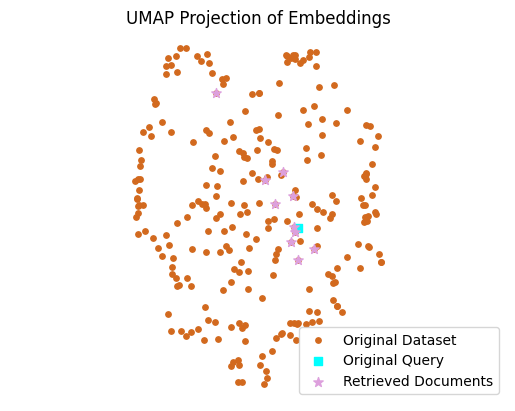

In [17]:
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=15, c="chocolate", label="Original Dataset")
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=40, marker='s',c="cyan", label="Original Query")
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=50, marker="*", c="plum", label="Retrieved Documents")
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP Projection of Embeddings')
plt.legend(loc="best");
plt.axis('off');

### Generate Hypothetical Answer (HyDE)

In [18]:
def generate_answer(query, model="llama-3.1-70b-versatile"):
    messages = [
        {
            "role": "system",
            "content": (
                "You are a helpful financial research assistant specializing in corporate governance, "
                "regulatory compliance, and financial analysis. Use information from the Ministry of Corporate "
                "Affairs Annual Report 2023-24 to answer the query concisely and accurately."
            )
        },
        {"role": "user", "content": f"The question is: {query}. Provide a detailed answer based on the MCA Annual Report 2023-24."}
    ]
    response = client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

generated_answer = generate_answer(query)

print(generated_answer)

According to the Ministry of Corporate Affairs (MCA) Annual Report 2023-24, the key changes made to the Companies Act in the last fiscal year are as follows:

1. **Decriminalization of Offences**: The MCA has continued to decriminalize certain offences under the Companies Act, 2013, to reduce the compliance burden on companies. As per the report, a total of 131 sections have been decriminalized, and 34 have been omitted.

2. **Producer Companies**: Amendments were made to the provisions related to Producer Companies, allowing them to carry out activities related to production, processing, and marketing of their products.

3. **Foreign Investment**: The MCA has simplified the process of foreign investment in Indian companies by introducing an online platform for reporting foreign investment.

4. **Corporate Social Responsibility (CSR)**: The report highlights the amendments made to CSR provisions, which include the introduction of a new framework for CSR implementation, allowing compani

### Generate Hypothetical Answer (HyDE)

In [19]:
answer_embeddings = distilroberta([generated_answer])

In [20]:
results = collection.query(query_embeddings=answer_embeddings, 
                           n_results=10,
                           include=['documents', 'embeddings'])

retrieved_documents2 = results['documents'][0]

for document in retrieved_documents2:
    print(document)
    print('==========================================')

. (iii) Convergence of Indian Accounting Standards with International Financial Reporting Standards (IFRS). (iv) Implementation of Competition Act through the Competition Commission of India (CCI). 1 (v) Implementation of IBC, 2016. (vi) Implementation of e-Governance in MCA. (vii) Building systems for early detection of irregularities in corporate functioning. (viii) Conducting Investor Education and Awareness Programmes. (ix) Investigation of serious frauds through the Serious Fraud Investigation Ofce (SFIO). (x) Management of the cadre of the Indian Corporate Law Service (ICLS). (xi) Providing administrative guidance to Statutory and attached organizations, namely, IICA, SFIO, CCI, NFRA, IEPFA, NCLT, NCLAT, and IBBI
CHAPTER-I OVERVIEW 1.1.1 The mandate of the Ministry of Corporate Affairs (MCA), inter alia, includes the administration of a wide range of statutes for the regulation of the corporate sector, as given below: (i) The Companies Act, 2013/The Companies Act, 1956. (ii) The

In [21]:
retrieved_docs_embeddings = results['embeddings'][0]
original_query_embeddings = distilroberta([query])

projected_original_query_embedding = project_embeddings(original_query_embeddings, umap_projector)
projected_generated_answer_embedding = project_embeddings(answer_embeddings, umap_projector)
projected_retrieved_embeddings = project_embeddings(retrieved_docs_embeddings, umap_projector)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 141.54it/s]


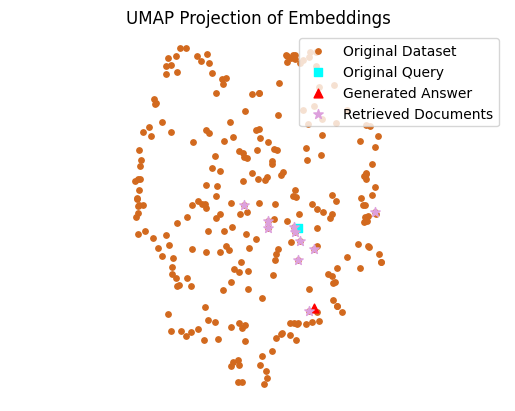

In [30]:
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=15, c="chocolate", label="Original Dataset")
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=40, marker='s',c="cyan", label="Original Query")
plt.scatter(projected_generated_answer_embedding[:, 0], projected_generated_answer_embedding[:, 1], s=40,  marker='^', c="red", label="Generated Answer")
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=50, marker="*", c="plum", label="Retrieved Documents")
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP Projection of Embeddings')
plt.legend(loc="upper right");
plt.axis('off');

### Generate Multiple Hypothetical Answers (HyDE)

In [23]:
generated_answers = [generate_answer(query) for i in range(5)]

for idx, answer in enumerate(generated_answers, start=1):
    print(f"========== Answer: {idx} ============\n\n")
    print(answer)

========== Answer: 1 ============


According to the Ministry of Corporate Affairs (MCA) Annual Report 2023-24, the key changes made to the Companies Act in the last fiscal year include:

1. **Decriminalization of certain offenses**: The MCA has decriminalized 131 provisions of the Companies Act, 2013, by omitting the punishment of imprisonment in respect of 23 offenses and reducing the fine for 108 offenses. This change aims to reduce the compliance burden on companies and promote ease of doing business.

2. **Introduction of Benign Warning and Compounding**: The report states that the MCA has introduced a new system of "Benign Warning" for minor and technical defaults. This allows companies to rectify minor defaults without facing severe penalties.

3. **Simplification of Corporate Social Responsibility (CSR) provisions**: The MCA has simplified the CSR provisions to make them more effective and less burdensome for companies. The report mentions that the CSR mandate has been clarifie

### Calculate Average Embedding of Generated Answers

In [24]:
answers_embeddings = distilroberta(generated_answers)
answers_embeddings = np.array(answers_embeddings)
answers_embeddings.shape

(5, 768)

In [25]:
avg_answers_embeddings = answers_embeddings.mean(axis=0)
avg_answers_embeddings.shape

(768,)

In [26]:
results = collection.query(query_embeddings=avg_answers_embeddings.reshape(1,-1),
                           n_results=10,
                           include=['documents', 'embeddings'])

retrieved_documents3 = results['documents'][0]

for document in retrieved_documents3:
    print(document)
    print('==========================================')

CHAPTER-I OVERVIEW 1.1.1 The mandate of the Ministry of Corporate Affairs (MCA), inter alia, includes the administration of a wide range of statutes for the regulation of the corporate sector, as given below: (i) The Companies Act, 2013/The Companies Act, 1956. (ii) The Limited Liability Partnership Act, 2008. (iii) The Competition Act, 2002. (iv) The Insolvency and Bankruptcy Code, 2016. (v) The Chartered Accountants Act, 1949. (vi) The Cost Accountants Act, 1959. (vii) The Company Secretaries Act, 1980. (viii) The Societies Registration Act, 1860 and Indian Partnership Act, 1932 (in centrally administered areas). (ix) The Companies (Donations to National Funds) Act, 1951. Functions 1.1.2 The main responsibilities of the Ministry are as follows: ( ) Administration of the provisions of the Companies Act, 2013, and also pending/ ongoing works as regards the Companies Act, 1956. (ii) Formulation of Rules and Regulations under various statutes administered by the Ministry
CHAPTER-I
OVERVI

### Project and Visualize Average HyDE Results

In [27]:
retrieved_docs_embeddings = results['embeddings'][0]
original_query_embeddings = distilroberta([query])

projected_original_query_embedding = project_embeddings(original_query_embeddings, umap_projector)
projected_generated_answers_embedding = project_embeddings(answers_embeddings, umap_projector)
projected_avg_answers_embedding = project_embeddings(avg_answers_embeddings.reshape(1,-1), umap_projector)
projected_retrieved_embeddings = project_embeddings(retrieved_docs_embeddings, umap_projector)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 106.16it/s]


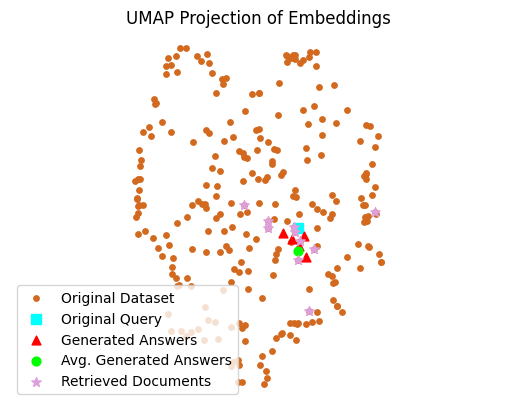

In [32]:
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=15, c="chocolate", label="Original Dataset")
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=50,marker='s',c="cyan", label="Original Query")
plt.scatter(projected_generated_answers_embedding[:, 0], projected_generated_answers_embedding[:, 1],s=40, marker='^', c="red", label="Generated Answers")
plt.scatter(projected_avg_answers_embedding[:, 0], projected_avg_answers_embedding[:, 1], s=40, c="lime", label="Avg. Generated Answers")
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=50, marker="*", c="plum", label="Retrieved Documents")
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP Projection of Embeddings')
plt.legend(loc="best");
plt.axis('off');